This notebook inspects the 5D dataset and calculate the sample drift using virtual dark field images

In [1]:
import hyperspy.api as hs
import numpy as np
import matplotlib.pyplot as plt
import SeqIO

In [2]:
%matplotlib notebook

In [3]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=4,
                      threads_per_worker=4,
                      dashboard_address=':8704')
client = Client(cluster)

In [4]:
dc = SeqIO.load_folder('data/',lazy=True,nav_shape=[500,160,160],chunk_shape=[1,160,160])

In [5]:
dc.set_signal_type('electron_diffraction')
dc.unit = "k_A^-1"
dc.beam_energy=200
dc.diffraction_calibration=0.01239

In [6]:
dc.data

dask.array<get_image_chunk, shape=(500, 160, 160, 128, 256), dtype=float32, chunksize=(1, 160, 160, 128, 256), chunktype=numpy.ndarray>

In [7]:
dc_exp = dc.inav[50:55,50:55,100]

In [8]:
dc_exp.compute()

<IPython.core.display.Javascript object>


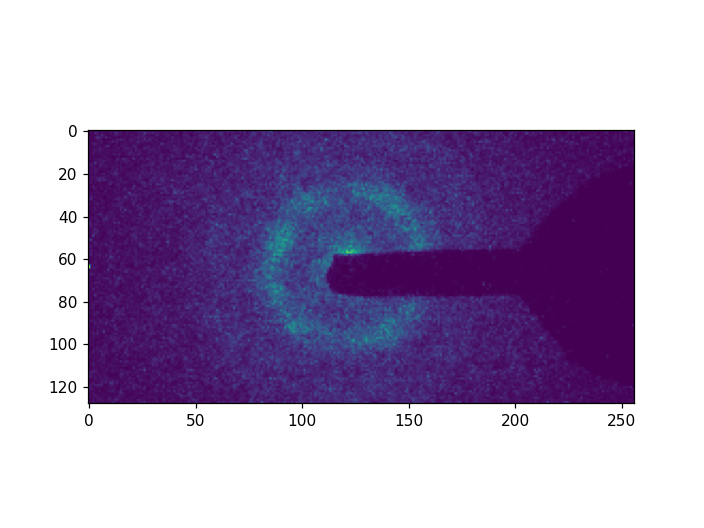

In [10]:
plt.figure()
plt.imshow(dc_exp.mean())
plt.show()

### Calculate virtual dark field image series

In [11]:
df_ref_l = dc.isig[1:50,:].sum(axis=(-1,-2),rechunk=False)#+dc.isig[206:,:].sum(axis=(-1,-2),rechunk=False)

In [12]:
df_ref_l.data

dask.array<sum-aggregate, shape=(500, 160, 160), dtype=float32, chunksize=(1, 160, 160), chunktype=numpy.ndarray>

In [13]:
df_ref_l.compute()

In [14]:
df_ref_l

<BaseSignal, title: , dimensions: (160, 160, 500|)>

In [3]:
df_ref = hs.load('dr_ref.hspy')

In [15]:
df_ref_l.save('dr_ref.hspy',chunks=(1,160,160))

In [16]:
from pystackreg import StackReg
import pystackreg

In [17]:
df_ref = hs.load('dr_ref.hspy')

<IPython.core.display.Javascript object>


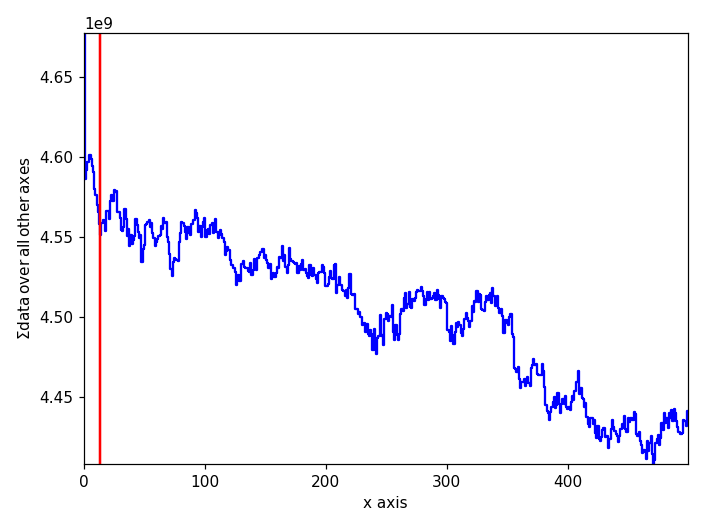

<IPython.core.display.Javascript object>


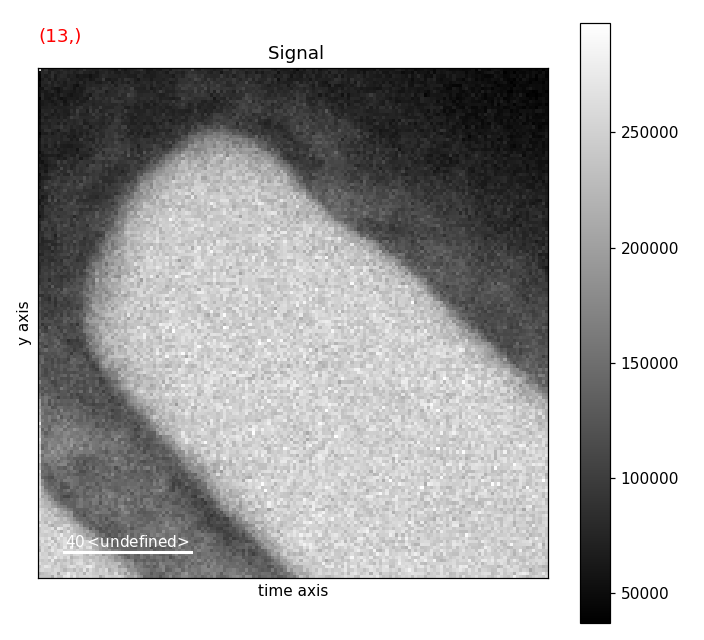

In [18]:
df_ref.transpose(navigation_axes=[-1]).plot()

In [19]:
# Croping the first row to work around SeqIO loading issue
img_ref = df_ref.inav[1:,1:].data

### Measure sample drift using pystackreg package

In [20]:
sr = StackReg(StackReg.TRANSLATION)

In [21]:
tmat = sr.register_stack(img_ref,axis=0,reference='first',verbose=True)
reg = sr.transform_stack(df_ref.data)

100%|█████████████████████████████████████████████████████████████████████████████████| 499/499 [00:08<00:00, 58.05it/s]


In [22]:
df_reg = hs.signals.Signal2D(reg)

<IPython.core.display.Javascript object>


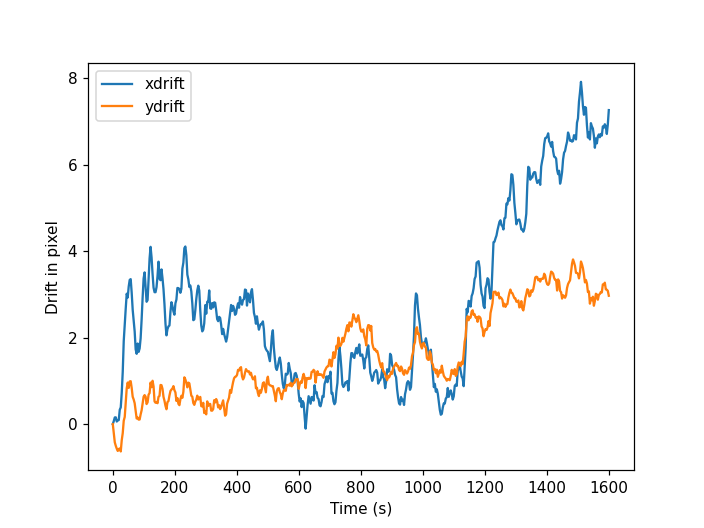

In [23]:
plt.figure()
plt.plot(np.linspace(0,500*3.2,500),tmat[:,0,2],label='xdrift')
plt.plot(np.linspace(0,500*3.2,500),tmat[:,1,2],label='ydrift')
#plt.plot(np.linspace(0,2400*2,2400),tmat_pix[:,0,2],label='xdrift_pix')
#plt.plot(np.linspace(0,2400*2,2400),tmat_pix[:,1,2],label='ydrift_pix')

plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Drift in pixel')
plt.show()

### Inspect registered VDF time series

<IPython.core.display.Javascript object>


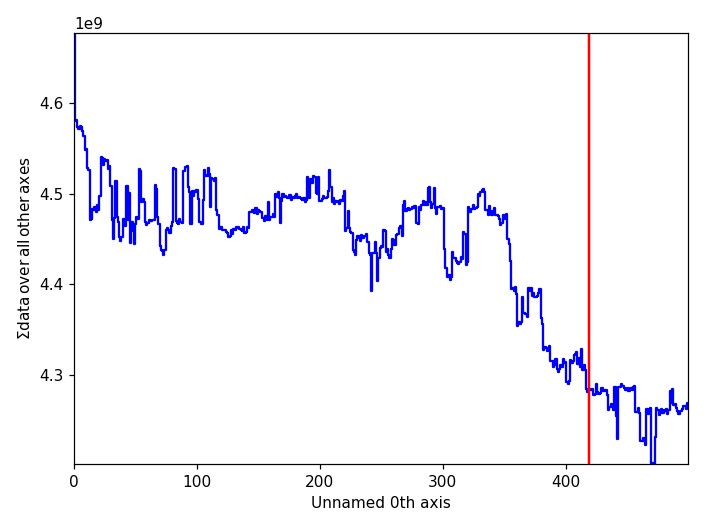

<IPython.core.display.Javascript object>


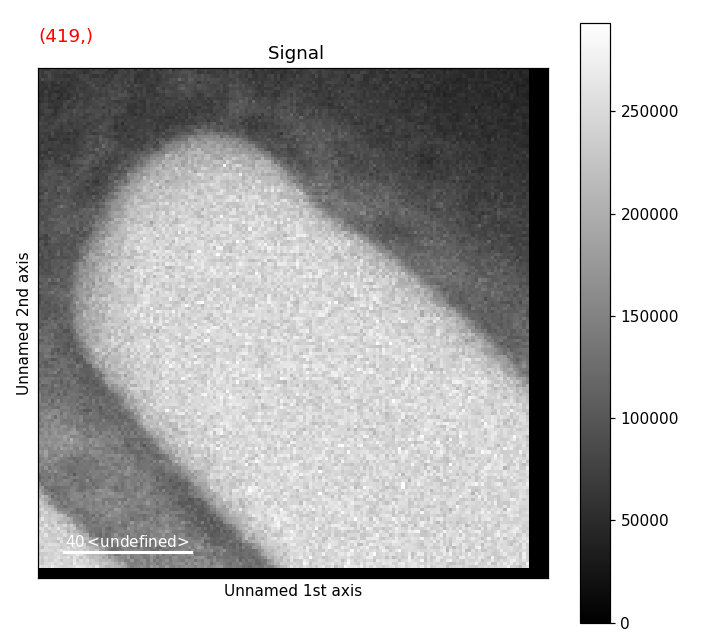

In [26]:
df_reg.plot()

In [27]:
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

<IPython.core.display.Javascript object>


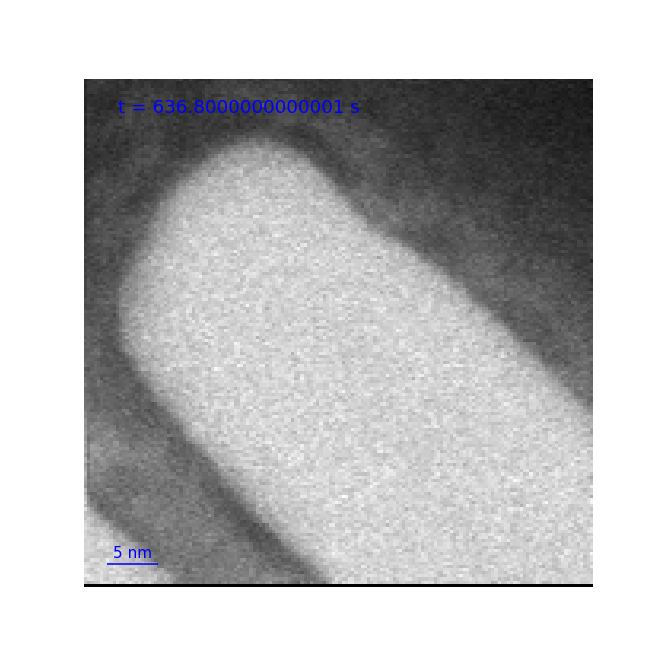

In [31]:
fig, ax = plt.subplots(figsize=[6,6])
im = ax.imshow(df_reg.inav[0].data,cmap='gray',vmin=1e4,vmax=3e5)

#cax = fig.add_axes([ax[0].get_position().x1+0.01,ax[0].get_position().y0,0.02,ax[0].get_position().height])
ax.set_yticks([])
ax.set_xticks([])

ax.axis('off')

txt = plt.text(10,10,'t = 0 s',fontsize='large',color='b')

def run(frame):
    txt.set_text('t = '+str(frame*3.2)+' s')
    im.set_data(df_reg.inav[frame].data)
    #fig.colorbar(im, ax=ax,shrink=0.7)
    return im

ani = animation.FuncAnimation(fig,run,frames=np.arange(0,500,1),interval=50)

scalebar = AnchoredSizeBar(ax.transData,
                           16.1, '5 nm', 'lower left', 
                           pad=0.5,
                           borderpad=1,
                           color='b',
                           label_top=True,
                           frameon=False,
                           size_vertical=.25)
ax.add_artist(scalebar)

plt.show()

<IPython.core.display.Javascript object>


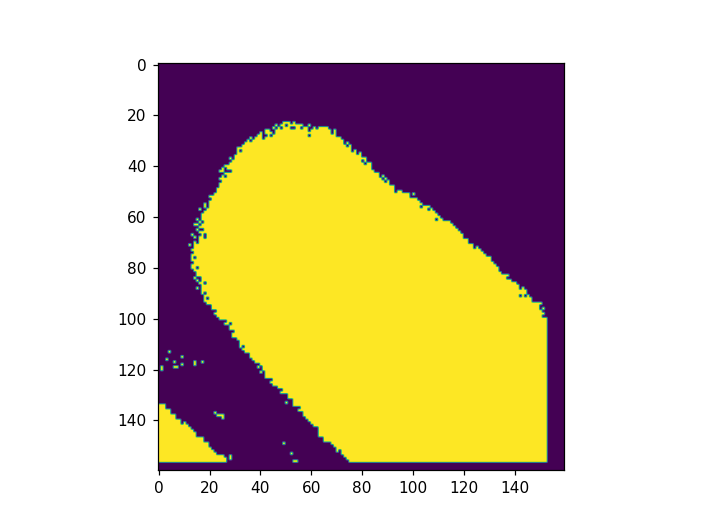

In [34]:
plt.figure()
plt.imshow(df_reg.inav[-2].data>1.8e5)
plt.show()

In [35]:
np.save('reg_ref.npy',df_reg.inav[-2].data)

<IPython.core.display.Javascript object>


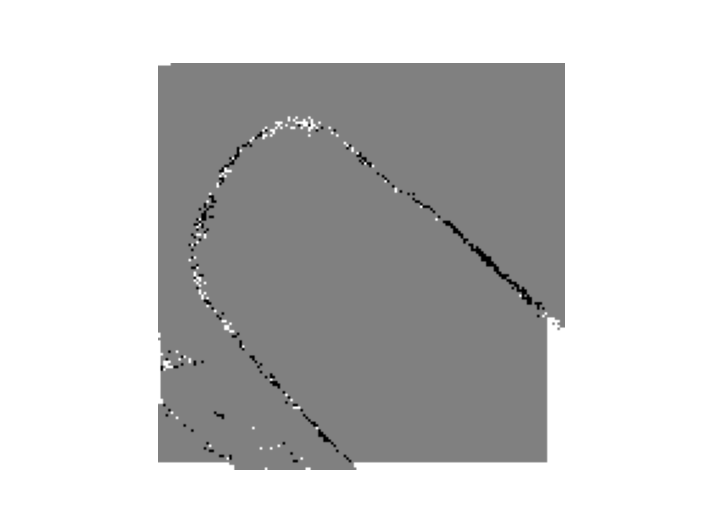

(-0.5, 159.5, 159.5, -0.5)

In [36]:
plt.figure()
plt.imshow((df_reg.inav[0].data>1.8e5).astype(int)-(df_reg.inav[-2].data>1.8e5).astype(int),cmap='gray')
plt.axis('off')

In [37]:
np.save('shift_subpix.npy',tmat)